In [151]:
# Author: Tian Yun
import os
from collections import defaultdict

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

target_domain = "block"  # ["block", "kitchen"]
target_domain_num_cases = 12 if target_domain == "kitchen" else 30

In [152]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)

In [153]:
case_category_tuples = {
    "kitchen": {
        "Single Goal, Correct Steps": [1,2,3],
        "Multiple Goal, Correct Steps": [5,6],  # skip case 4
        "Single Goal, Wrong Steps": [7,8,9,10],
        "Multiple Goal, Wrong Steps": [11,12],
    },
    "block": {
        "Single Goal, Correct Steps": [1,2,3,4,5],
        "Multiple Goal, Correct Steps": [6,7,8,9],
        "Single Goal, Wrong Steps": [11,12,13,23,24,25,26,27,28,29],
        "Multiple Goal, Wrong Steps": [14],
    }
#     "block": {
#         "Single Goal, Correct Steps": [1,2,3,4,5],
#         "Multiple Goal, Correct Steps": [6,7,8,9,10],
#         "Single Goal, Wrong Steps": [11,12,13,23,24,25,26,27,28,29],
#         "Multiple Goal, Wrong Steps": [14,15,16,17,18,19,20,21,22,30],
#     }
}

baseline_agent_dict = {
    "random": "Random - Correct",
    "htn": "HTN",
    "fixed_always_ask": "ALWAYS-ASK",
    "pomdp": "DGR-POMDP",
    "SIPS": "SIPS",
}

# 1. Parsing HTN-based Results

In [129]:
def get_case_name(case_id):
    # This function can be replaced by a case_id to case_category mapping
    for case_cat, cases in case_category_tuples[target_domain].items():
        if case_id in cases:
            return case_cat

In [156]:
class parseArguments:
    def __init__(self):
        self.base_dir_path = f"./outputs/{target_domain}"
        self.agent_type = ["fixed_always_ask", "pomdp", "htn"]
        #self.hyperparams = "dp17_sn5_df0.95_e1_wp-5_qr5_qp-5_oh0.76_dt0.001"
        self.hyperparams = "dp19_sn6_df0.95_e1.0_wp-5_qr5_qp-5_oh0.76_dt0.001"
        self.reliability_scores = [0.8, 0.9, 0.95, 0.99]
        self.num_goals = 5
        self.num_cases = 2
        self.category_list = ["single_correct", "single_wrong", "multi_correct", "multi_wrong"]        
        
args = parseArguments()

In [157]:
# Load acc and std csv files
goal_acc_csv_dict, goal_sem_csv_dict = {},{}
plan_acc_csv_dict, plan_sem_csv_dict = {},{}

for agent in args.agent_type:
    # Load goal accuracy and standard error of mean
    goal_acc_csv_dict[agent] = pd.read_csv(os.path.join(args.base_dir_path, agent, args.hyperparams, "goal_accuracy.csv"))
    goal_sem_csv_dict[agent] = pd.read_csv(os.path.join(args.base_dir_path, agent, args.hyperparams, "goal_std.csv"))
    
    # Load plan accuracy and standard error of mean
    plan_acc_csv_dict[agent] = pd.read_csv(os.path.join(args.base_dir_path, agent, args.hyperparams, "plan_accuracy.csv"))
    plan_sem_csv_dict[agent] = pd.read_csv(os.path.join(args.base_dir_path, agent, args.hyperparams, "plan_std.csv"))

In [159]:
# Load runtime/num_questions/reward csv files
cumu_runtime_mean_csv_dict, cumu_runtime_sem_csv_dict = {},{}
cumu_questions_mean_csv_dict, cumu_questions_sem_csv_dict = {},{}
cumu_reward_mean_csv_dict, cumu_reward_sem_csv_dict = {},{}

all_cases = np.concatenate(list(case_category_tuples[target_domain].values()))

for agent in args.agent_type:

    df_mean_time = goal_acc_csv_dict[agent].copy()  # same dataframe format
    df_sem_time = goal_acc_csv_dict[agent].copy()
    df_mean_questions = goal_acc_csv_dict[agent].copy()  # same dataframe format
    df_sem_questions = goal_acc_csv_dict[agent].copy()
    df_mean_reward = goal_acc_csv_dict[agent].copy()  # same dataframe format
    df_sem_reward = goal_acc_csv_dict[agent].copy()

    for sensor_reliability in args.reliability_scores:
        
        row_id = 0
        for case_id in range(1, target_domain_num_cases+1):
            
            if case_id not in all_cases:
                # skip cases that do not belong to the target domain
                continue

            case_csv_name = f"Episode-Case{case_id}_{sensor_reliability}.csv"
            curr_df = pd.read_csv(os.path.join(args.base_dir_path, agent, args.hyperparams, "episode_reward", case_csv_name))
            x = []

            # Process runtime
            curr_mean_time = curr_df["normalized_time"].mean()
            curr_sem_time = curr_df["normalized_time"].std() / np.sqrt(len(curr_df))
            df_mean_time.loc[df_mean_time["Case_Num"]==case_id, [str(sensor_reliability)]] = curr_mean_time
            df_sem_time.loc[df_mean_time["Case_Num"]==case_id, [str(sensor_reliability)]] = curr_sem_time
            #df_mean_time.loc[row_id, str(sensor_reliability)] = curr_mean_time
            #df_sem_time.loc[row_id, str(sensor_reliability)] = curr_sem_time
            
            # Process number of questions asked
            curr_mean_questions = curr_df["normalized_num_question_asked"].mean()
            curr_sem_questions = curr_df["normalized_num_question_asked"].std() / np.sqrt(len(curr_df))
            df_mean_questions.loc[df_mean_questions["Case_Num"]==case_id, [str(sensor_reliability)]] = curr_mean_questions
            df_sem_questions.loc[df_sem_questions["Case_Num"]==case_id, [str(sensor_reliability)]] = curr_sem_questions
            #df_mean_questions.loc[row_id, str(sensor_reliability)] = curr_mean_questions
            #df_sem_questions.loc[row_id, str(sensor_reliability)] = curr_sem_questions
            
            # Process discounted rewards
            curr_mean_reward = curr_df["cumu_discounted_reward"].mean()
            curr_sem_reward = curr_df["cumu_discounted_reward"].std() / np.sqrt(len(curr_df))
            df_mean_reward.loc[df_mean_reward["Case_Num"]==case_id, [str(sensor_reliability)]] = curr_mean_reward
            df_sem_reward.loc[df_sem_reward["Case_Num"]==case_id, [str(sensor_reliability)]] = curr_sem_reward
            #df_mean_reward.loc[row_id, str(sensor_reliability)] = curr_mean_reward
            #df_sem_reward.loc[row_id, str(sensor_reliability)] = curr_sem_reward
            
            row_id += 1
            
    cumu_runtime_mean_csv_dict[agent] = df_mean_time.copy()
    cumu_runtime_sem_csv_dict[agent] = df_sem_time.copy()
    cumu_questions_mean_csv_dict[agent] = df_mean_questions.copy()
    cumu_questions_sem_csv_dict[agent] = df_sem_questions.copy()
    cumu_reward_mean_csv_dict[agent] = df_mean_reward.copy()
    cumu_reward_sem_csv_dict[agent] = df_sem_reward.copy()

In [198]:
goal_acc_csv_dict["fixed_always_ask"].drop(goal_acc_csv_dict["fixed_always_ask"].loc[~goal_acc_csv_dict["fixed_always_ask"]["Case_Num"].isin(all_cases)].index, inplace=True)

In [199]:
goal_acc_csv_dict["fixed_always_ask"].loc[goal_acc_csv_dict["fixed_always_ask"]["Case_Num"].isin(all_cases)]

,Case_Num,0.99,0.95,0.9,0.8
0,1,1.0000,1.0000,1.0000,0.9333
1,2,1.0000,0.9917,0.9750,0.9750
2,3,1.0000,1.0000,1.0000,0.9917
3,4,1.0000,1.0000,1.0000,0.7667
4,5,0.9929,0.9893,0.9929,0.9679
5,6,1.0000,1.0000,0.9792,0.8750
6,7,1.0000,1.0000,0.9875,0.9042
7,8,1.0000,1.0000,1.0000,0.8750
8,9,1.0000,0.9925,0.9600,0.9450
10,11,0.9875,0.8688,0.8750,0.9125


In [200]:
# Filter out not needed rows in aggregated results

aggregated_results = [
    goal_acc_csv_dict, 
    goal_sem_csv_dict,
    plan_acc_csv_dict,
    plan_sem_csv_dict,
    cumu_runtime_mean_csv_dict,
    cumu_runtime_sem_csv_dict,
    cumu_questions_mean_csv_dict,
    cumu_questions_sem_csv_dict,
    cumu_reward_mean_csv_dict,
    cumu_reward_sem_csv_dict,
]

for aggregated_result in aggregated_results:
    for agent in args.agent_type:
        curr_df = aggregated_result[agent]
        to_be_removed_rows = curr_df.loc[~curr_df["Case_Num"].isin(all_cases)].index
        curr_df.drop(to_be_removed_rows, inplace=True)

# 2. Parsing SIPS Results
- Run this after you run Section 1

In [203]:
class parseArguments:
    def __init__(self):
        self.base_dir_path = f"./outputs/{target_domain}"
        self.agent_type = ["fixed_always_ask", "htn"]
        self.hyperparams = "dp17_sn5_df0.95_e1_wp-5_qr5_qp-5_oh0.76_dt0.001"
        self.reliability_scores = [0.8, 0.9, 0.95, 0.99]
        self.num_sub_goals = 5
        self.num_cases = 2
        self.category_list = ["single_correct", "single_wrong", "multi_correct", "multi_wrong"]        
        
args = parseArguments()

In [204]:
def get_top1_accuracy_single_correct_category(data_df, label, num_sub_goals):
    """ Top-1 accuracy for goal inference. """
    goal_inference_correct = 0
    for row_id in range(1, len(data_df)):  # ignore the initial state
        row = data_df.iloc[row_id]
        
        all_goal_probs = []
        for goal_id in range(num_sub_goals):
            all_goal_probs.append(row[f"goal_probs_{goal_id}"])
        prediction = np.array(all_goal_probs).argmax()
    
        if prediction == label:
            goal_inference_correct += 1
            
    accuracy = goal_inference_correct / (len(data_df) - 1)  # ignore the initial state
    return accuracy


def get_top1_accuracy_other_category(data_df, labels, num_sub_goals):
    """ Top-1 accuracy for goal inference. """
    goal_inference_correct = 0
    for row_id in range(len(labels)):
        row = data_df.iloc[row_id+1]  # ignore the initial state
        
        all_goal_probs = []
        for goal_id in range(num_sub_goals):
            all_goal_probs.append(row[f"goal_probs_{goal_id}"])
        prediction = np.array(all_goal_probs).argmax()
    
        if prediction == labels[row_id]:
            goal_inference_correct += 1
            
    accuracy = goal_inference_correct / (len(data_df) - 1)  # ignore the initial state
    return accuracy

In [205]:
# Processing "optimal" folder, including ["single_correct", "multi_correct"]

agent = "SIPS"
goal_acc_csv_dict["SIPS"] = {c:defaultdict(dict) for c in case_category_tuples[target_domain].keys()}
cumu_runtime_mean_csv_dict["SIPS"] = {c:defaultdict(dict) for c in case_category_tuples[target_domain].keys()}
cumu_runtime_sem_csv_dict["SIPS"] = {c:defaultdict(dict) for c in case_category_tuples[target_domain].keys()}

data_dir_path = os.path.join(args.base_dir_path, agent, "optimal")
goal_labels_df = pd.read_csv(os.path.join(args.base_dir_path, "SIPS", "SIPS_blockdomain_groundtruth_multiple_goal.csv"))

for sensor_reliability in args.reliability_scores:

    # "single_correct"
    for goal in range(0, 5):
        curr_df = pd.read_csv(
            os.path.join(data_dir_path, f"block-words-{sensor_reliability}", f"block-words_problem_0_goal{goal}.csv")
        )

        curr_goal_acc = get_top1_accuracy_single_correct_category(curr_df, goal, args.num_sub_goals)
        goal_acc_csv_dict["SIPS"]["Single Goal, Correct Steps"][str(sensor_reliability)][str(goal)] = curr_goal_acc
        
        cumu_runtime_mean_csv_dict["SIPS"]["Single Goal, Correct Steps"][str(sensor_reliability)][str(goal)] = curr_df["step_durs"].mean()
        cumu_runtime_sem_csv_dict["SIPS"]["Single Goal, Correct Steps"][str(sensor_reliability)][str(goal)] = curr_df["step_durs"].std()
        
    # "multi_correct"
    for goal in range(5, 7+1):
        curr_df = pd.read_csv(
            os.path.join(data_dir_path, f"block-words-{sensor_reliability}", f"block-words_problem_0_goal{goal}.csv")
        )
        
        goal_labels = goal_labels_df[f"block-words_problem_0_goal{goal}"]
        goal_labels = np.array(goal_labels.tolist())
        goal_labels = goal_labels[~np.isnan(goal_labels)]
        
        curr_goal_acc = get_top1_accuracy_other_category(curr_df, goal_labels, args.num_sub_goals)
        goal_acc_csv_dict["SIPS"]["Multiple Goal, Correct Steps"][str(sensor_reliability)][str(goal)] = curr_goal_acc
        
        cumu_runtime_mean_csv_dict["SIPS"]["Multiple Goal, Correct Steps"][str(sensor_reliability)][str(goal)] = curr_df["step_durs"].mean()
        cumu_runtime_sem_csv_dict["SIPS"]["Multiple Goal, Correct Steps"][str(sensor_reliability)][str(goal)] = curr_df["step_durs"].std()


In [206]:
# Processing "suboptimal" folder, including ["single_wrong", "multi_wrong"]

data_dir_path = os.path.join(args.base_dir_path, agent, "suboptimal")
goal_labels_df = pd.read_csv(os.path.join(args.base_dir_path, "SIPS", "SIPS_blockdomain_groundtruth_multiple_goal.csv"))

for sensor_reliability in args.reliability_scores:

    # "single_correct"
    for goal in range(0, 5):
        for case in range(args.num_cases):
            curr_df = pd.read_csv(
                os.path.join(data_dir_path, f"block-words-{sensor_reliability}", f"block-words_problem_0_goal{goal}_{case}.csv")
            )
            
            curr_goal_acc = get_top1_accuracy_single_correct_category(curr_df, goal, args.num_sub_goals)
            goal_acc_csv_dict["SIPS"]["Single Goal, Wrong Steps"][str(sensor_reliability)][f"{goal}_{case}"] = curr_goal_acc
            
            cumu_runtime_mean_csv_dict["SIPS"]["Single Goal, Wrong Steps"][str(sensor_reliability)][f"{goal}_{case}"] = curr_df["step_durs"].mean()
            cumu_runtime_sem_csv_dict["SIPS"]["Single Goal, Wrong Steps"][str(sensor_reliability)][f"{goal}_{case}"] = curr_df["step_durs"].std()
        
    # "multi_correct"
    for goal in range(args.num_sub_goals, 7+1):        
        for case in range(args.num_cases):
            curr_df = pd.read_csv(
                os.path.join(data_dir_path, f"block-words-{sensor_reliability}", f"block-words_problem_0_goal{goal}_{case}.csv")
            )

            goal_labels = goal_labels_df[f"block-words_problem_0_goal{goal}_{case}"]
            goal_labels = np.array(goal_labels.tolist())
            goal_labels = goal_labels[~np.isnan(goal_labels)]

            curr_goal_acc = get_top1_accuracy_other_category(curr_df, goal_labels, args.num_sub_goals)
            goal_acc_csv_dict["SIPS"]["Multiple Goal, Wrong Steps"][str(sensor_reliability)][f"{goal}_{case}"] = curr_goal_acc
            
            cumu_runtime_mean_csv_dict["SIPS"]["Multiple Goal, Wrong Steps"][str(sensor_reliability)][f"{goal}_{case}"] = curr_df["step_durs"].mean()
            cumu_runtime_sem_csv_dict["SIPS"]["Multiple Goal, Wrong Steps"][str(sensor_reliability)][f"{goal}_{case}"] = curr_df["step_durs"].std()
        

In [207]:
!ls ./outputs/block

SIPS             fixed_always_ask htn              pomdp
acc_viz          ga.png           pa.png


In [208]:
goal_acc_csv_dict["SIPS"]

{'Single Goal, Correct Steps': defaultdict(dict,
             {'0.8': {'0': 0.6666666666666666,
               '1': 1.0,
               '2': 1.0,
               '3': 1.0,
               '4': 0.5714285714285714},
              '0.9': {'0': 0.6666666666666666,
               '1': 0.6666666666666666,
               '2': 1.0,
               '3': 1.0,
               '4': 0.5714285714285714},
              '0.95': {'0': 0.6666666666666666,
               '1': 0.6666666666666666,
               '2': 1.0,
               '3': 1.0,
               '4': 0.5714285714285714},
              '0.99': {'0': 1.0,
               '1': 0.6666666666666666,
               '2': 1.0,
               '3': 1.0,
               '4': 0.5714285714285714}}),
 'Multiple Goal, Correct Steps': defaultdict(dict,
             {'0.8': {'5': 0.3333333333333333,
               '6': 0.5,
               '7': 0.3333333333333333},
              '0.9': {'5': 0.5, '6': 0.5, '7': 0.4166666666666667},
              '0.95': {'5': 0.416

# 3. Visualizations

## 3.1. Goal Accuracy vs. Reliability Score

In [209]:
# Get aggregated results for each case for each agent
goal_acc_line_df = defaultdict(dict)
goal_sem_line_df = defaultdict(dict)
x_ticklabels = None

# HTN-based agents
for case, case_nums in case_category_tuples[target_domain].items():
    #print(case, case_nums)
    for agent in args.agent_type:
        curr_df = goal_acc_csv_dict[agent].copy()
        #print(curr_df)
        curr_df = curr_df[curr_df["Case_Num"].isin(case_nums)]
        curr_df.drop("Case_Num", axis=1, inplace=True)
        goal_acc_line_df[case][agent] = list(curr_df.mean().to_dict().values())[::-1]  # Make the sensor reliability ascending
        
        curr_df = goal_sem_csv_dict[agent].copy()
        curr_df = curr_df[curr_df["Case_Num"].isin(case_nums)]
        curr_df.drop("Case_Num", axis=1, inplace=True)
        goal_sem_line_df[case][agent] = list(curr_df.mean().to_dict().values())[::-1] # Make the sensor reliability ascending
        x_ticklabels = curr_df.columns.to_list()[::-1]  # Make the sensor reliability ascending


# SIPS
for category, category_values in goal_acc_csv_dict["SIPS"].items():
    goal_acc_list, goal_sem_list = [],[]
    for sensor_reliability, case_results in category_values.items():
        curr_results = np.array(list(case_results.values()))
        goal_acc_list.append(curr_results.mean())
        goal_sem_list.append(curr_results.std())
    goal_acc_line_df[category]["SIPS"] = goal_acc_list.copy()
    goal_sem_line_df[category]["SIPS"] = goal_sem_list.copy()


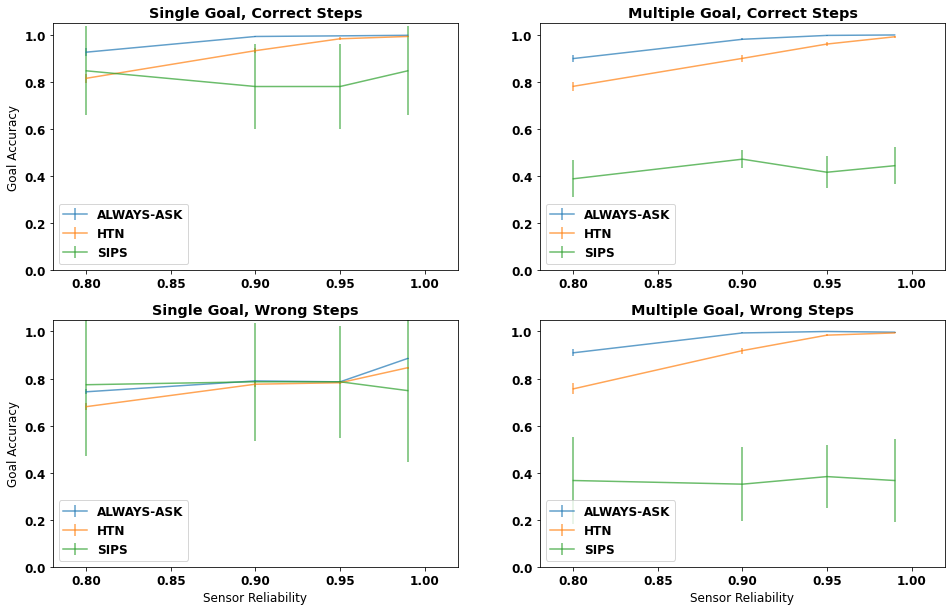

In [210]:
# Visualize Performance by Case Category
x = [float(val) for val in x_ticklabels]

n_row = 2
n_col = 2
fig, ax = plt.subplots(n_row, n_col, figsize=(16,10))

for case_id, case in enumerate(case_category_tuples[target_domain].keys()):
    
    plot_row = case_id // n_col
    plot_col = case_id % n_col

    for agent in (args.agent_type + ["SIPS"]):
        acc = goal_acc_line_df[case][agent]
        sem = goal_sem_line_df[case][agent]
        ax[plot_row][plot_col].errorbar(x, acc, yerr=sem, label=baseline_agent_dict[agent], alpha=0.7)
    
    #if case_id == 0:
    ax[plot_row][plot_col].legend(loc="lower left")
    
    ax[plot_row][plot_col].set_title(case, fontweight="bold")
    if plot_col == 0:
        ax[plot_row][plot_col].set_ylabel("Goal Accuracy")
    if plot_row == 1:
        ax[plot_row][plot_col].set_xlabel("Sensor Reliability")
    
    ax[plot_row][plot_col].set_ylim([0.0, 1.05])
    ax[plot_row][plot_col].set_xlim([0.78, 1.02])

In [211]:
goal_acc_line_df

defaultdict(dict,
            {'Single Goal, Correct Steps': {'fixed_always_ask': [0.9269200000000002,
               0.99358,
               0.9962,
               0.9985799999999999],
              'htn': [0.81594,
               0.9333400000000001,
               0.9837999999999999,
               0.99358],
              'SIPS': [0.8476190476190476,
               0.7809523809523808,
               0.7809523809523808,
               0.8476190476190476]},
             'Multiple Goal, Correct Steps': {'fixed_always_ask': [0.8997999999999999,
               0.981675,
               0.998125,
               1.0],
              'htn': [0.781875, 0.900625, 0.9614500000000001, 0.992275],
              'SIPS': [0.38888888888888884,
               0.47222222222222227,
               0.4166666666666667,
               0.4444444444444444]},
             'Single Goal, Wrong Steps': {'fixed_always_ask': [0.7437400000000001,
               0.79,
               0.78594,
               0.8853199999

## 3.2. Plan Accuracy vs. Reliability Score
- No SIPS for this visualization

In [212]:
# Get aggregated results for each case for each agent
plan_acc_line_df = defaultdict(dict)
plan_sem_line_df = defaultdict(dict)
x_ticklabels = None

for case, case_nums in case_category_tuples[target_domain].items():
    #print(case, case_nums)
    for agent in args.agent_type:
        curr_df = plan_acc_csv_dict[agent].copy()
        #print(curr_df)
        curr_df = curr_df[curr_df["Case_Num"].isin(case_nums)]
        curr_df.drop("Case_Num", axis=1, inplace=True)
        plan_acc_line_df[case][agent] = list(curr_df.mean().to_dict().values())[::-1]  # Make the sensor reliability ascending
        
        curr_df = plan_sem_csv_dict[agent].copy()
        curr_df = curr_df[curr_df["Case_Num"].isin(case_nums)]
        curr_df.drop("Case_Num", axis=1, inplace=True)
        plan_sem_line_df[case][agent] = list(curr_df.mean().to_dict().values())[::-1] # Make the sensor reliability ascending
        x_ticklabels = curr_df.columns.to_list()[::-1]  # Make the sensor reliability ascending

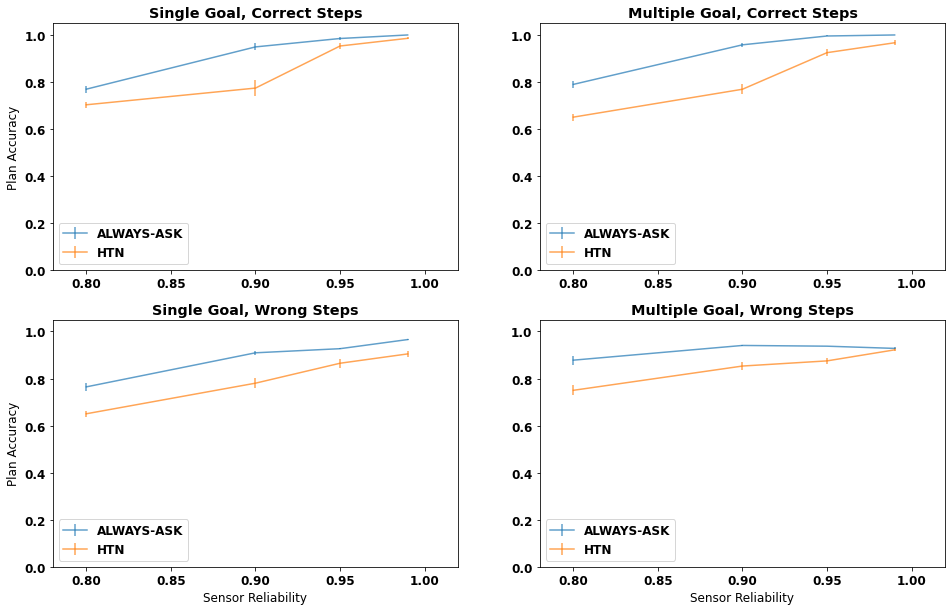

In [213]:
# Visualize Performance by Case Category
x = [float(val) for val in x_ticklabels]

n_row = 2
n_col = 2
fig, ax = plt.subplots(n_row, n_col, figsize=(16,10))

for case_id, case in enumerate(case_category_tuples[target_domain].keys()):
    
    plot_row = case_id // n_col
    plot_col = case_id % n_col

    for agent in (args.agent_type):
        acc = plan_acc_line_df[case][agent]
        sem = plan_sem_line_df[case][agent]
        ax[plot_row][plot_col].errorbar(x, acc, yerr=sem, label=baseline_agent_dict[agent], alpha=0.7)

    #if case_id == 0:
    ax[plot_row][plot_col].legend(loc="lower left")
        
    ax[plot_row][plot_col].set_title(case, fontweight="bold")
    if plot_col == 0:
        ax[plot_row][plot_col].set_ylabel("Plan Accuracy")
    if plot_row == 1:
        ax[plot_row][plot_col].set_xlabel("Sensor Reliability")
    ax[plot_row][plot_col].set_ylim([0.0, 1.05])
    ax[plot_row][plot_col].set_xlim([0.78, 1.02])

In [214]:
plan_acc_line_df

defaultdict(dict,
            {'Single Goal, Correct Steps': {'fixed_always_ask': [0.76974,
               0.9492799999999999,
               0.985,
               1.0],
              'htn': [0.7033400000000001,
               0.7742800000000001,
               0.9530999999999998,
               0.98572]},
             'Multiple Goal, Correct Steps': {'fixed_always_ask': [0.79,
               0.9581249999999999,
               0.995625,
               1.0],
              'htn': [0.6508499999999999,
               0.7693500000000001,
               0.9248,
               0.9668749999999999]},
             'Single Goal, Wrong Steps': {'fixed_always_ask': [0.76469,
               0.9093899999999999,
               0.9268799999999999,
               0.96563],
              'htn': [0.6503300000000001,
               0.7803199999999999,
               0.865,
               0.9046799999999999]},
             'Multiple Goal, Wrong Steps': {'fixed_always_ask': [0.8781,
               0.9406,
  

## 3.3. Aggregating #Questions/Rewards/Runtime

In [215]:
table = {
    agent: {
        "runtime": {},
        "reward": {},
        "questions": {},
    } 
    for agent in args.agent_type
}
table["SIPS"] = {"runtime": {}}

# HTN-based
for agent in args.agent_type:
    for sensor_reliability in args.reliability_scores:
        table[agent]["runtime"][str(sensor_reliability)] = cumu_runtime_mean_csv_dict[agent][str(sensor_reliability)].mean()
        table[agent]["reward"][str(sensor_reliability)] = cumu_reward_mean_csv_dict[agent][str(sensor_reliability)].mean()
        table[agent]["questions"][str(sensor_reliability)] = cumu_questions_mean_csv_dict[agent][str(sensor_reliability)].mean()

# SIPS
for sensor_reliability in args.reliability_scores:
    for category in case_category_tuples[target_domain].keys():
        table["SIPS"]["runtime"][str(sensor_reliability)] = np.array(list(cumu_runtime_sem_csv_dict["SIPS"][category][str(sensor_reliability)].values())).mean()


In [218]:
# For easy copy to create latex table
sensor_reliability = 0.80  # [0.80, 0.90, 0.95, 0.99]
target_col = "questions"  # ["runtime", "reward", "questions"]

print(target_col)
for agent in ["htn", "fixed_always_ask", "SIPS"]:
    # Note that SIPS don't have #questions or reward, so there will be error messages for those 
    print(table[agent][target_col][str(sensor_reliability)])
    

questions
0.0
1.0


KeyError: 'questions'

In [219]:
table

{'fixed_always_ask': {'runtime': {'0.8': 2.060334013167591,
   '0.9': 1.8941764140331319,
   '0.95': 1.6077990738036376,
   '0.99': 1.3997297336785566},
  'reward': {'0.8': -34.43907585636971,
   '0.9': -56.83188252910462,
   '0.95': -62.442002085652305,
   '0.99': -68.11504417012563},
  'questions': {'0.8': 1.0, '0.9': 1.0, '0.95': 1.0, '0.99': 1.0}},
 'htn': {'runtime': {'0.8': 7.98108506918876,
   '0.9': 1.5709087385063372,
   '0.95': 1.3635264936859408,
   '0.99': 1.0453604128655223},
  'reward': {'0.8': -15.122599440127697,
   '0.9': -10.974186038913299,
   '0.95': -5.694585258269534,
   '0.99': -3.616723934102088},
  'questions': {'0.8': 0.0, '0.9': 0.0, '0.95': 0.0, '0.99': 0.0}},
 'SIPS': {'runtime': {'0.8': 43.17311702160409,
   '0.9': 41.615277101757044,
   '0.95': 40.65444044330605,
   '0.99': 40.93398803473696}}}